# Data Retrieval

In [1]:
import pandas as pd
import csv
import re
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor

In [2]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}/calendar.csv'

sf_file = file_url.format('sf_airbnb')
ok_file = file_url.format('ok_airbnb')
sc_file = file_url.format('sc_airbnb')

In [3]:
# Loaded price by date information for each city

pricing_sf = pd.read_csv(sf_file, parse_dates=['date'])
pricing_ok = pd.read_csv(ok_file, parse_dates=['date'])
pricing_sc = pd.read_csv(sc_file, parse_dates=['date'])

print(pricing_sf.shape, pricing_ok.shape, pricing_sc.shape)

(2420680, 4) (1057770, 4) (2068820, 4)


In [4]:
# Concatenated all files into one
# Created keys for each file for future references

frames = [pricing_sf, pricing_ok, pricing_sc]
keys = ['pricing_sf', 'pricing_ok', 'pricing_sc']

df_pricing = pd.concat(frames, keys=keys)

df_pricing.head(10)

listing_id       date available price
pricing_sf 0         958 2019-08-05         f   NaN
           1         958 2019-08-04         f   NaN
           2         958 2019-08-03         f   NaN
           3         958 2019-08-02         f   NaN
           4         958 2019-08-01         f   NaN
           5         958 2019-07-31         f   NaN
           6         958 2019-07-30         f   NaN
           7         958 2019-07-29         f   NaN
           8         958 2019-07-28         f   NaN
           9         958 2019-07-27         f   NaN

# Data Exploration

## Smaller Set of Data

In [5]:
# Filter to houses that are available and have listing prices

df_pricing_smaller = df_pricing[df_pricing['available']=='t']
df_pricing_smaller = df_pricing_smaller.copy()

print('Dimension for df_pricing_smaller: ', df_pricing_smaller.shape)
print ('\nNumber of Unique ids: ', df_pricing_smaller.listing_id.nunique())

Dimension for df_pricing_smaller:  (2588352, 4)

Number of Unique ids:  13452


In [6]:
df_pricing_smaller.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

## Data Format

In [7]:
def apply2df(df, column_names, function):
    """
    This enables various functions to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to (list), function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

### Currency

In [8]:
# Noted currencies are formated as strings and need to be converted to float

def currency2float(string):
    """
    Convert currency to float
    """
    float_ = float(str(string).strip('$').replace(',',''))
    return float_

In [9]:
# Converted price to float format

curriencies = ['price']

df_pricing_smaller = apply2df(df_pricing_smaller, curriencies, currency2float)

## Outliers

In [10]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

df_pricing_smaller.price.describe(percentiles=percentiles)

count    2.588352e+06
mean     2.056189e+02
std      7.335415e+02
min      1.000000e+01
5%       4.000000e+01
10%      5.000000e+01
25%      7.800000e+01
50%      1.290000e+02
75%      2.090000e+02
90%      3.500000e+02
95%      5.000000e+02
max      1.024520e+05
Name: price, dtype: float64

In [11]:
# Removed outliers based on 'price'. Use 5% and 95% percentiles as cutoff

five_percentile = np.percentile(df_pricing_smaller.price, 5)
ninety_five_percentile = np.percentile(df_pricing_smaller.price, 95)

df_pricing_smaller = df_pricing_smaller[(
                        df_pricing_smaller.price>=five_percentile)
                        & (df_pricing_smaller.price<=ninety_five_percentile)]

In [12]:
print ('df_pricing_smaller dimensions: ', df_pricing_smaller.shape)

df_pricing_smaller dimensions:  (2346265, 4)


## Null Values

In [13]:
df_pricing_smaller.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [14]:
df_pricing_smaller.shape

(2346265, 4)

In [15]:
columns2display = ['date', 'price']

df_pricing_smaller[columns2display].describe(include='all')

,date,price
count,2346265,2.346265e+06
unique,375,NaN
top,2018-11-03 00:00:00,NaN
freq,8671,NaN
first,2018-08-06 00:00:00,NaN
last,2019-08-15 00:00:00,NaN
mean,NaN,1.537473e+02
std,NaN,9.694863e+01
min,NaN,4.000000e+01
25%,NaN,8.000000e+01


## Seasonality Data

### Added Month and Day-of-Week(DOW) Features

In [16]:
# Added 'month' column to extract month of date
# Added 'day_of_week' column to extact day of week. 
# Default format: Monday=0, Sunday=6

df_pricing_smaller['month'] = df_pricing_smaller['date'].dt.month
df_pricing_smaller['day_of_week'] = df_pricing_smaller['date'].dt.weekday


print('df_pricing_smaller dimensions', df_pricing_smaller.shape)
display(df_pricing_smaller.head())

df_pricing_smaller dimensions (2346265, 6)


listing_id       date available  price  month  day_of_week
pricing_sf 63         958 2019-05-02         t  181.0      5            3
           64         958 2019-05-01         t  181.0      5            2
           65         958 2019-04-30         t  181.0      4            1
           66         958 2019-04-29         t  181.0      4            0
           67         958 2019-04-28         t  181.0      4            6

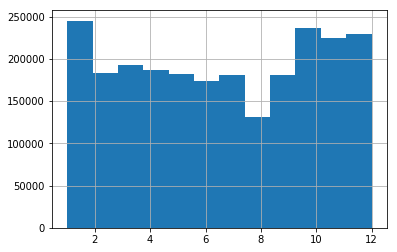

In [17]:
# Checked the price distribution by month

df_pricing_smaller.month.hist(bins=12)

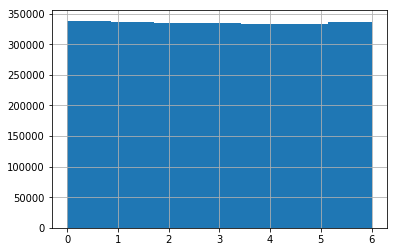

In [18]:
# Checked the price distribution by day of week

df_pricing_smaller.day_of_week.hist(bins=7)

### Pricing By Month by DOW

In [19]:
# Group by month by day of week, and calculate an average pricing

df_pricing_by_mon_dow = df_pricing_smaller  \
                            .groupby(['listing_id', 'month', 'day_of_week'])  \
                            .price.mean()  \
                            .reset_index()
df_pricing_by_mon_dow.head(100)

,listing_id,month,day_of_week,price
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0
5,958,1,5,185.0
6,958,1,6,180.0
7,958,2,0,179.0
8,958,2,1,179.0
9,958,2,2,179.0


In [20]:
# Check for null values if any

df_pricing_by_mon_dow.isnull().sum()

listing_id     0
month          0
day_of_week    0
price          0
dtype: int64

In [21]:
# Rename the average price column to avoid confusion

df_pricing_by_mon_dow.rename(columns={'price':'price_by_mon_dow'}, inplace=True)

In [22]:
df_pricing_by_mon_dow.shape

(625086, 4)

In [23]:
df_pricing_by_mon_dow.head()

,listing_id,month,day_of_week,price_by_mon_dow
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0


In [24]:
columns2display = ['price_by_mon_dow']

df_pricing_by_mon_dow[columns2display].describe()

,price_by_mon_dow
count,625086.000000
mean,154.025145
std,97.041053
min,40.000000
25%,80.000000
50%,128.000000
75%,199.000000
max,500.000000


### Convert Month, DOW Info to Dummy Variables

In [25]:
def get_month(number):
    """
    Given a number, return the name of month.
    
    """
    month_lookup = {1:'Jan.', 2:'Feb.', 3:'Mar.', 4:'Apr.', 5:'May.', 6:'Jun.',
                    7:'Jul.', 8:'Aug.', 9:'Sep.', 10:'Oct.', 11:'Nov.', 12:'Dec.'}
    
    return month_lookup[number]

In [26]:
def get_dow(number):
    """
    Given a number, return the day of week (dow)
    
    """
    weekday_lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                      4:'Friday', 5:'Saturday', 6:'Sunday'}
    
    return weekday_lookup[number]

In [27]:
# Added names for month, and day of week(dow) informaiton

df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['month'], get_month )
df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['day_of_week'], get_dow )

In [28]:
# Converted month, and dow information to dummy variables

df_pricing_final = pd.get_dummies(df_pricing_by_mon_dow, 
                                  prefix='',
                                  prefix_sep='',
                                  columns=['month', 'day_of_week'])

print ('df_pricing_final dimensions: ', df_pricing_final.shape)
df_pricing_final.head()

df_pricing_final dimensions:  (625086, 21)


,listing_id,price_by_mon_dow,Apr.,Aug.,Dec.,Feb.,Jan.,Jul.,Jun.,Mar.,...,Nov.,Oct.,Sep.,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,958,180.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,958,179.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,958,183.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [29]:
df_pricing_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.', 'May.', 'Nov.', 'Oct.', 'Sep.',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

## Combined Seasonality Data with Previously Identified Features

In [30]:
# Loaded listings with identified important features

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

listings = pkl_file.format('df_listings_selected_features')

df_listings_features = pd.read_pickle(listings)

print ('df_listings_features dimensions: ', df_listings_features.shape)
df_listings_features.head()

df_listings_features dimensions:  (9062, 108)


,id,bedrooms,cleaning_fee,room_type_Entire home/apt,city_San Francisco,accommodates,city_Oakland,reviews_per_month,bathrooms,host_listings_count,...,amenities_Pets live on this property,is_location_exact_f,room_type_Shared room,amenities_Coffee maker,neighbourhood_cleansed_Potrero Hill,amenities_Heating,property_type_Townhouse,amenities_Microwave,ref_district,ref_jurisdiction
0,958,1.0,100.0,1,1,3,0,1.38,1.0,1,...,1,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
1,5858,2.0,100.0,1,1,5,0,0.99,1.0,2,...,0,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
2,7918,1.0,50.0,0,1,2,0,0.16,4.0,10,...,0,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
3,8142,1.0,50.0,0,1,2,0,0.15,4.0,10,...,0,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
4,8567,2.0,125.0,1,1,6,0,0.27,1.0,1,...,0,0,0,1,0,1,0,1,San Francisco,SAN FRANCISCO


In [31]:
df_listings_features.columns

Index(['id', 'bedrooms', 'cleaning_fee', 'room_type_Entire home/apt',
       'city_San Francisco', 'accommodates', 'city_Oakland',
       'reviews_per_month', 'bathrooms', 'host_listings_count',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=108)

In [32]:
# Combined listing data with seaonality information we just created

df_final = pd.merge(left=df_pricing_final, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [33]:
df_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=129)

In [34]:
# Dropped duplicate columns

duplicate_columns = ['id']
df_final.drop(duplicate_columns, axis=1, inplace=True)

df_final.shape

(407498, 128)

### Features with High Correlation

In [35]:
# Create correlation matrix
# Select upper triangle of correlation matrix

corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [36]:
# Find index of feature columns with correlation greater than 0.90

thresold = 0.90
to_drop = [column for column in upper.columns if any(upper[column] >= thresold)]

to_drop

[]

In [37]:
# Drop features that have high correlation

df_final.drop(to_drop, axis=1, inplace=True)

In [38]:
df_final.shape

(407498, 128)

In [39]:
# Store the data prior to modeling
# When there're changes, mark file_updated as true. Changes'll be written to local files
# Otherwise, mark file_updated as false. Data will be loaded from existing files

file_updated = True
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings_seasonality = pkl_file.format('listings_seasonality')


if file_updated:
    with open(listings_seasonality, 'wb') as file:
        pd.to_pickle(df_final, file)
else:
    try: 
        with open(listings_seasonality, 'rb') as file:
            df_final = pd.read_pickle(file)
    except:
        with open(listings_seasonality, 'wb') as file:
            pd.to_pickle(df_final, file)

# Modeling

In [40]:
df_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=128)

In [41]:
df_final.select_dtypes(include =['object']).columns

Index(['ref_district', 'ref_jurisdiction'], dtype='object')

In [42]:
# Multiple modelings will be performed for price prediction
# Data include 'listing_id', which will be used for stratified sampling

X = df_final.drop(['price_by_mon_dow', 'ref_district', 'ref_jurisdiction'], axis=1)
y = df_final.loc[:, ['listing_id', 'price_by_mon_dow']]

## Model Preprocessing

### Train and Test Sets Splits

In [43]:
# Stratified sampling to prevent information leakage
# Identified all available listing_ids and split by listing_ids

grp_by_listing_ids = df_final.groupby('listing_id').first().reset_index().listing_id
listing_ids = list(grp_by_listing_ids)

In [44]:
num_of_grps = len(grp_by_listing_ids)
training_ids = np.random.choice(listing_ids, int(num_of_grps*0.7),
                                replace=False)

print(len(training_ids))
training_ids

5814


array([17590102,  9196933, 12525362, ..., 11636621,  1740537, 16454916])

In [45]:
testing_ids = set(grp_by_listing_ids) - set (training_ids)

len(testing_ids)

2493

In [46]:
# Stratified sampling: splited train and test sets. 
# Dropped 'listing_id' column

X_train = X[X['listing_id'].isin(training_ids)].drop('listing_id', axis=1)
X_test = X[X['listing_id'].isin(testing_ids)].drop('listing_id', axis=1)

y_train = y[y['listing_id'].isin(training_ids)].drop('listing_id', axis=1).values.ravel()
y_test = y[y['listing_id'].isin(testing_ids)].drop('listing_id', axis=1).values.ravel()

print(len(X_train), len(X_test), len(y_train), len(y_test))

284923 122575 284923 122575


### Feature Normalization

In [47]:
ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Simple Linear Regression

In [48]:
# Model-LR

model=sm.OLS(y_train, sm.add_constant(X_train_trans))
fit=model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     4551.
Date:                Mon, 18 Feb 2019   Prob (F-statistic):               0.00
Time:                        12:41:10   Log-Likelihood:            -1.5352e+06
No. Observations:              284923   AIC:                         3.071e+06
Df Residuals:                  284799   BIC:                         3.072e+06
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        147.9623      0.099   1491.611      0.000     147.768     148.157
x1         -7.446e+10   1.67e+11     -0.446      0.656   -4.02e+11    2.53e+11
x2         -8.534e+10   1.91e+11     -0.446      0.656   -4.61e+11     2.9e+11
x3         -8.461e+10    1.9e+11     -0.446      0.656   -4.57e+11    2.87e+11
x4         -8.116e+10   1.82e+11     -0.446      0.656   -4.38e+11    2.76e+11
x5         -8.496e+10   1.91e+11     -0.446      0.656   -4.59e+11    2.89e+11
x6         -7.166e+10   1.61e+11     -0.446      0.656   -3.87e+11    2.43e+11
x7         -7.164e+10   1.61e+11     -0.446      0.656   -3.87e+11    2.43e+11
x8          -7.45e+10   1.67e+11     -0.446      0.656   -4.02e+11    2.53e+11
x9         -7.357e+10   1.65e+11     -0.446      0.656   -3.97e+11     2.5e+11
x10        -8.878e+10   1.99e+11     -0.446      0.656   -4.79e+11    3.02e+11
x11        -8.846e+10   1.98e+11     -0.446      0.656   -4.77e+11       3e+11
x12        -8.428e+10   1.89e+11     -0.446      0.656   -4.55e+11    2.86e+11
x13         2.286e+11   1.44e+12      0.159      0.874    -2.6e+12    3.05e+12
x14         2.275e+11   1.43e+12      0.159      0.874   -2.58e+12    3.04e+12
x15          2.27e+11   1.43e+12      0.159      0.874   -2.58e+12    3.03e+12
x16         2.277e+11   1.44e+12      0.159      0.874   -2.59e+12    3.04e+12
x17         2.279e+11   1.44e+12      0.159      0.874   -2.59e+12    3.05e+12
x18         2.259e+11   1.42e+12      0.159      0.874   -2.57e+12    3.02e+12
x19         2.261e+11   1.43e+12      0.159      0.874   -2.57e+12    3.02e+12
x20           21.2841      0.175    121.335      0.000      20.940      21.628
x21            8.4280      0.141     59.721      0.000       8.151       8.705
x22           23.3773      0.161    144.760      0.000      23.061      23.694
x23            9.0659      0.599     15.140      0.000       7.892      10.240
x24           22.9003      0.222    103.345      0.000      22.466      23.335
x25           -7.6070      0.446    -17.065      0.000      -8.481      -6.733
x26           -3.7059      0.180    -20.553      0.000      -4.059      -3.353
x27            3.4365      0.119     28.932      0.000       3.204       3.669
x28            5.4829      0.155     35.289      0.000       5.178       5.787
x29           -3.0022      0.187    -16.040      0.000      -3.369      -2.635
x30            0.2740      0.131      2.087      0.037       0.017       0.531
x31            4.8926      0.224     21.890      0.000       4.454       5.331
x32            2.9824      0.136     21.898      0.000       2.715       3.249
x33            5.2002      0.133     39.124      0.000       4.940       5.461
x34          -11.2602      0.157    -71.638      0.000     -11.568     -10.952
x35           -0.5198      0.174     -2.982      0.003      -0.861      -0.178
x3

## Lasso

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [50]:
est = make_pipeline(PolynomialFeatures(), Lasso())

In [51]:
est.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'lasso', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [63]:
params ={'polynomialfeatures__degree':[1], 
         'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
        }

In [64]:
grid = GridSearchCV(est, param_grid=params, cv=3, 
                    return_train_score=True,  n_jobs =-1)
grid.fit(X_train_trans, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

In [54]:
grid.cv_results_

grid.cv_results_['params']
grid.cv_results_['mean_train_score']
grid.cv_results_['rank_test_score']

array([5, 4, 3, 2, 1], dtype=int32)

In [55]:
grid.cv_results_

{'mean_fit_time': array([414.61723828, 271.4545234 , 150.57445598,  51.64999437,
         14.81380002]),
 'std_fit_time': array([ 2.9682512 , 78.87036126, 26.36167191, 13.54234327,  0.64767319]),
 'mean_score_time': array([1.2023836 , 1.13117639, 0.95420694, 0.90907502, 1.04631472]),
 'std_score_time': array([0.26466895, 0.16094203, 0.39435332, 0.1141736 , 0.09591292]),
 'param_lasso__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_polynomialfeatures__degree': masked_array(data=[1, 1, 1, 1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 

In [56]:
grid.best_params_

{'lasso__alpha': 1, 'polynomialfeatures__degree': 1}

In [57]:
grid.cv_results_['params']

[{'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 1, 'polynomialfeatures__degree': 1}]

In [58]:
grid.best_score_

0.6093288889137937

In [ ]:
grid.b

In [ ]:
rand = GridSearchCV(est, param_distribution=params, cv=5)
grid.fit(X_train_trans, y_train)

## Random Forest

In [ ]:
# Model-Random Forest

rf = RandomForestRegressor(n_estimators=100, 
                           criterion='mse', 
                           random_state=42, 
                           verbose=1,
                           n_jobs=-1)
rf.fit(X_train_trans, y_train.ravel())

y_train_pred = rf.predict(X_train_trans)
y_test_pred = rf.predict(X_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

In [ ]:
df_final.listing_id.nunique()

In [ ]:
# Double check on price range. The range is as expected

y.describe(include='all')

In [ ]:
# Map feature importance with labels

feature_labels = X.columns
feature_tuples = zip (feature_labels, rf.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]

In [ ]:
# Order features based on importance

feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)
feature_lists

In [ ]:
features = [list_[0] for list_ in feature_lists]
features

In [ ]:
# 'ref_dist', 'ref_juri', 'ref_jurisdiction', 'price_by_month_week'


columns =['listing_id']
columns.extend(features)
columns.extend(['ref_district', 'ref_jurisdiction', 'price_by_month_dow'])

In [ ]:
df_data = df_final[columns]
df_data.head()

In [ ]:
df_data.shape

In [ ]:
df_data.rename(columns={'price_by_month_dow':'price'}, inplace=True)

In [ ]:
df_data.isnull().sum()

In [ ]:
temp_df = df_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].copy()

days = temp_df.apply(lambda x: x.idxmax(), axis=1)
days

In [ ]:
csv_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

csv_path = csv_file.format('airbnb_data')

df_data.to_csv(csv_path)

In [ ]:
# This is to create visual to show seasonality

df_visual = pd.merge(left=df_pricing_by_mon_dow, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [ ]:
# df_visual = df_final.copy()

In [ ]:
df_visual.shape

In [ ]:
df_visual.columns

In [ ]:
df_by_dow = df_visual  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_by_dow

In [ ]:
df_by_dow = df_visual  \
                          .groupby(['ref_district', 'month'])  \
                          .price_by_month_dow.mean()
df_by_dow

In [ ]:
df_visual_ent_apart = df_visual[df_visual['room_type_Entire home/apt']==1 ]
df_visual_sing_room = df_visual[df_visual['room_type_Entire home/apt']!=1 ]

print(df_visual_ent_apart.shape, df_visual_sing_room.shape )

In [ ]:
df_visual_ent_apart.ref_district.describe

In [ ]:
# df_visual_entire_apartment_sf = df_visual_entire_apartment[
#                            df_visual_entire_apartment['ref_district']=='San Francisco']
# df_visual_entire_apartment_scz = df_visual_entire_apartment[df_visual_entire_apartment['ref_district']=='Santa Clara']

# print(df_visual_entire_apartment_sf.shape, df_visual_entire_apartment_scz.shape )

In [ ]:
# df_visual_entire_apartment_sf.listing_id.nunique()

In [ ]:
# df_visual_entire_apartment_scz.listing_id.nunique()

In [ ]:
# Weekly pattern for entire apartment

df_ent_apart_by_dow = df_visual_ent_apart  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_ent_apart_by_dow

In [ ]:
# Weekly pattern for single room

df_sing_room_by_dow = df_visual_sing_room  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_sing_room_by_dow

In [ ]:
# Montly Pattern for entire apartment

df_visual_ent_apart.groupby(['ref_district', 'month']).price_by_month_dow.mean()

In [ ]:
# Montly Pattern for single room

df_visual_sing_room.groupby(['ref_district', 'month']).price_by_month_dow.mean()